In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="m4db", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [2]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

TESTM4_quadruple_delay_full_monitoring_5sectimeout_90conns_1client_1attackers_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,4,4,proxy,microcloud,ubuntu1804-std
1,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,5,client1,microcloud,ubuntu1804-std
2,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,3,1,originserver,microcloud,ubuntu1804-std


In [3]:
exp_id = "TESTM4_quadruple_delay_full_monitoring_5sectimeout_90conns_1client_1attackers_newreala"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
dnid_map_node = {d:n for n,d in node_map_dnid.items()}
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(dnid_map_node)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'client1': 5, 'originserver': 1, 'proxy': 4}
{'client1': 2, 'originserver': 3, 'proxy': 4}
{2: 'client1', 3: 'originserver', 4: 'proxy'}
{5}
{2}
4


In [4]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,client1,1,26,101,1.643653e+09,1.643653e+09,98.111656
1,originserver,1,26,208,1.643653e+09,1.643653e+09,101.467478
2,proxy,1,26,336,1.643653e+09,1.643653e+09,101.923308


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

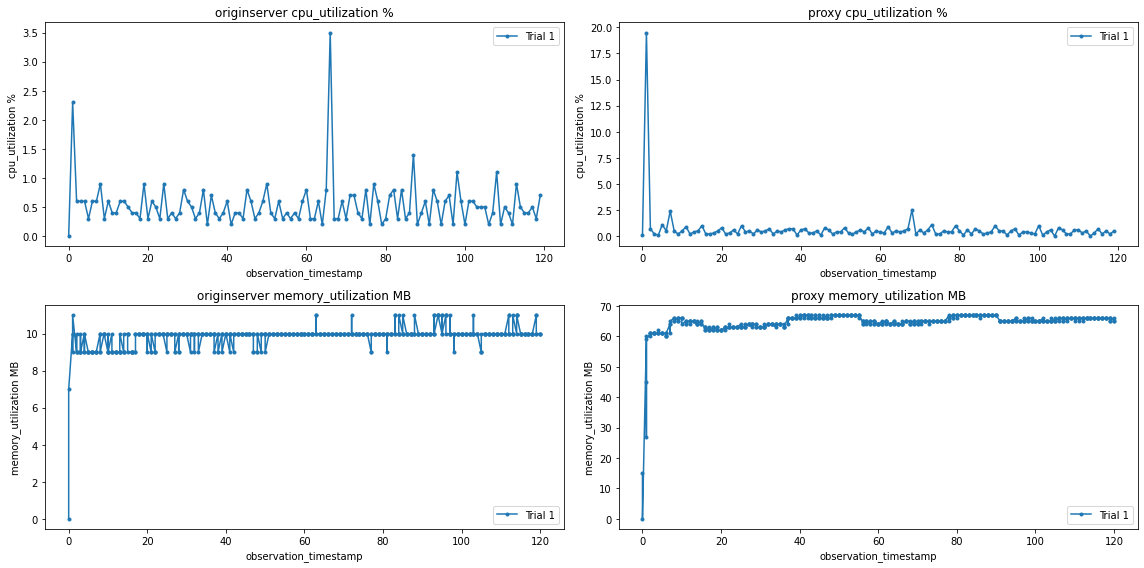

,observer_id,trial,observation_timestamp,metric_type,metric_value
0,originserver,1,1643652948,cpu_utilization,0.3
1,originserver,1,1643652948,memory_utilization,265.0
2,originserver,1,1643652948,memory_utilization,272.0
3,originserver,1,1643652949,cpu_utilization,2.6
4,originserver,1,1643652949,memory_utilization,275.0
...,...,...,...,...,...
1273,proxy,1,1643653068,memory_utilization,331.0
1274,proxy,1,1643653068,memory_utilization,330.0
1275,proxy,1,1643653069,memory_utilization,331.0
1276,proxy,1,1643653069,memory_utilization,330.0


In [5]:
# Plot the node metrics for each device

metrics_sql = f"""
SELECT nm.*
FROM node_metric nm
WHERE nm.observer_id IN ({','.join(map(str, dnid_map_node.keys()))})
ORDER BY nm.observer_id, nm.trial, nm.observation_timestamp, nm.metric_type
"""

metrics_df = pd.read_sql_query(metrics_sql, con)
con.commit()

# Replace dnids with human-readable node names
metrics_df.observer_id.replace(dnid_map_node, inplace=True)

metric_types = metrics_df.metric_type.unique()
node_names = metrics_df.observer_id.unique()
trials = metrics_df.trial.unique()

metric_type_map_extension = {
    "cpu_utilization": "%",
    "memory_utilization": "MB",
}

fig, axs = plt.subplots(len(node_names), len(metric_types))
for i, mt in enumerate(metric_types):
    for j, node_name in enumerate(node_names):
        for t in trials:
            # Filter each metric type observer node into its own tile, further filter by trial
            ax = axs[i, j]
            _df = metrics_df[(metrics_df["metric_type"] == mt) 
                             & (metrics_df["observer_id"] == node_name)
                             & (metrics_df["trial"] == t)]
            
            # Normalize the timestamp and metric value of the experiment
            _df["observation_timestamp"] -= min(_df["observation_timestamp"])
            _df["metric_value"] -= min(_df["metric_value"])
            
            _df.plot(kind="line", x="observation_timestamp", y="metric_value", marker=".", ax=ax, label=f"Trial {t}")

            ylabel = mt + " " + metric_type_map_extension[mt]
            ax.set_ylabel(ylabel)
            ax.set_title(node_name + " " + ylabel)

fig.tight_layout()
plt.show()

metrics_df

In [6]:
%%time

client_messages_sql = f"""
WITH client_msgs AS (
SELECT
    dn.exp_id,
	e.trial,
	e.observer_id,
    e.message_marker,
	e.observe_timestamp,
	m.src_id, 
    cm.coap_code,
	cm.coap_retransmitted
FROM
	event e
	JOIN deployed_node dn ON dn.dnid = e.observer_id
	JOIN message m ON e.message_id = m.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))}) -- all client dnids
ORDER BY
	e.observe_timestamp
), client_sends AS (
SELECT *
FROM client_msgs
WHERE src_id != {proxy_node_id} -- message source is not the proxy 
), client_recvs AS (
SELECT *
FROM client_msgs
WHERE src_id = {proxy_node_id} -- message source is the proxy 
), msgs_summary AS (
SELECT 
	cm.exp_id,
	cm.trial,
	cm.observer_id,
	cm.message_marker,
	COUNT(cm.*) AS num_observations,
	SUM(CASE WHEN cm.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM 
	client_msgs cm
GROUP BY
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
ORDER BY 
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
), timestamps_summary AS (
SELECT 
	cm.exp_id, 
	cm.trial, 
	cm.observer_id, 
	MIN(observe_timestamp) AS min_observe_timestamp, 
	MAX(observe_timestamp) AS max_observe_timestamp
FROM client_msgs cm
GROUP BY cm.exp_id, cm.trial, cm.observer_id
ORDER BY cm.exp_id, cm.trial, cm.observer_id
), main_table AS (
SELECT 
	cs.exp_id,
	cs.trial,
	cs.observer_id,
    cs.message_marker,
	1e3 * (MAX(cr.observe_timestamp) - MIN(cs.observe_timestamp)) AS rtt_ms_first_transmission,
	1e3 * (MAX(cr.observe_timestamp) - MAX(cs.observe_timestamp)) AS rtt_ms_last_transmission,
	-- MIN is ok to use as "first in aggregation group" since all 
	-- values are expected to be the same in the GROUP BY group
	MIN(cs.observe_timestamp) - MIN(min_observe_timestamp) AS send_time_sec,
	MAX(cr.observe_timestamp) - MIN(min_observe_timestamp) AS recv_time_sec,
	MIN(ms.num_observations) AS num_observations,
	MIN(ms.num_retransmissions) AS num_retransmissions
FROM 
	client_sends cs
	LEFT JOIN client_recvs cr
		ON cs.exp_id = cr.exp_id 
		AND cs.trial = cr.trial
		AND cs.observer_id = cr.observer_id
		AND cs.message_marker = cr.message_marker
	JOIN timestamps_summary ts
		ON cs.exp_id = ts.exp_id 
		AND cs.trial = ts.trial
		AND cs.observer_id = ts.observer_id
	, msgs_summary ms
WHERE
	cs.exp_id = ms.exp_id
	AND cs.trial = ms.trial
	AND cs.observer_id = ms.observer_id
	AND cs.message_marker = ms.message_marker
GROUP BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
ORDER BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
), rps_stats AS (
SELECT 
	mt.exp_id,
	mt.trial,
	mt.observer_id,
	COUNT(DISTINCT mt.message_marker) AS num_messages,
	MAX(mt.recv_time_sec) AS last_receive_time_sec,
	MIN(mt.send_time_sec) AS first_send_time_sec,
	COUNT(DISTINCT mt.message_marker) / (MAX(mt.recv_time_sec) - MIN(mt.send_time_sec)) AS average_rps
FROM main_table mt
GROUP BY mt.exp_id, mt.trial, mt.observer_id
)

SELECT mt.*, rs.num_messages, rs.average_rps
FROM main_table mt
JOIN rps_stats rs
	ON mt.exp_id = rs.exp_id
	AND mt.trial = rs.trial
	AND mt.observer_id = rs.observer_id
"""

rtts_df = pd.read_sql_query(client_messages_sql, con)
con.commit()

rtts_df

CPU times: user 7.51 ms, sys: 225 µs, total: 7.73 ms
Wall time: 13.2 ms


,exp_id,trial,observer_id,message_marker,rtt_ms_first_transmission,rtt_ms_last_transmission,send_time_sec,recv_time_sec,num_observations,num_retransmissions,num_messages,average_rps
0,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,1,4105.545759,1197.152853,0.000000,4.105546,4,1,26,0.26501
1,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,2,3814.669847,1615.922689,4.120102,7.934772,4,1,26,0.26501
2,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,3,4018.934965,1924.181938,7.937235,11.956170,4,1,26,0.26501
3,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,4,3814.327002,1282.510042,11.958603,15.772930,4,1,26,0.26501
4,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,5,4016.151905,1160.289049,15.775392,19.791544,4,1,26,0.26501
5,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,6,3813.785076,1136.047840,19.793921,23.607706,4,1,26,0.26501
6,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,7,4016.521931,1879.822969,23.610195,27.626717,4,1,26,0.26501
7,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,8,3813.349009,1136.689901,27.629006,31.442355,4,1,26,0.26501
8,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,9,4014.844179,1716.158152,31.444604,35.459448,4,1,26,0.26501
9,TESTM4_quadruple_delay_full_monitoring_5sectim...,1,2,10,3812.746048,1455.085993,35.461795,39.274541,4,1,26,0.26501


In [7]:
rtts_df[["rtt_ms_first_transmission", "rtt_ms_last_transmission"]].describe()

,rtt_ms_first_transmission,rtt_ms_last_transmission
count,25.000000,25.000000
mean,3921.635237,1481.836967
std,108.107676,283.890260
min,3811.827183,1084.984779
25%,3812.746048,1195.056200
50%,4013.560772,1550.264120
75%,4014.840126,1735.197067
max,4105.545759,1924.181938


<IPython.core.display.Javascript object>


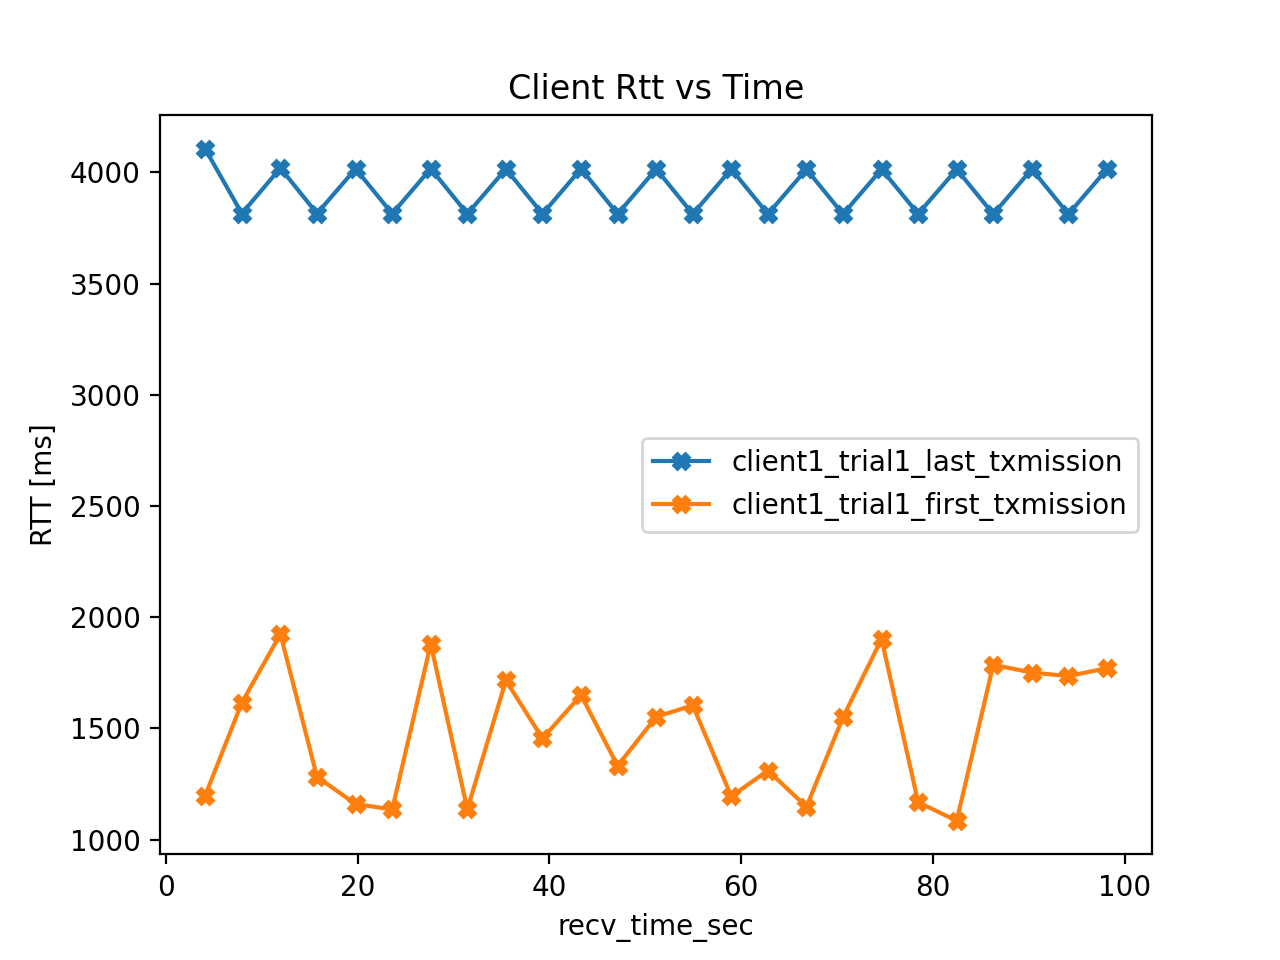

In [8]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {}

ax = None
kind = "line"
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        
        # RTT since first transmission
        last_txmission = label + "_last_txmission"
        plot_args = {"kind": kind,
                     "x": "recv_time_sec",
                     "y": "rtt_ms_first_transmission",
                     "label": last_txmission,
                     "marker": 'X'}
        if ax:
            plot_args["ax"] = ax
        
        ax = client_trial_df.plot(**plot_args)
        plot_args["ax"] = ax

        # RTT since last transmission
        first_txmission = label + "_first_txmission"
        plot_args["label"] = first_txmission
        plot_args["y"] = "rtt_ms_last_transmission"
        ax = client_trial_df.plot(**plot_args)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

<IPython.core.display.Javascript object>


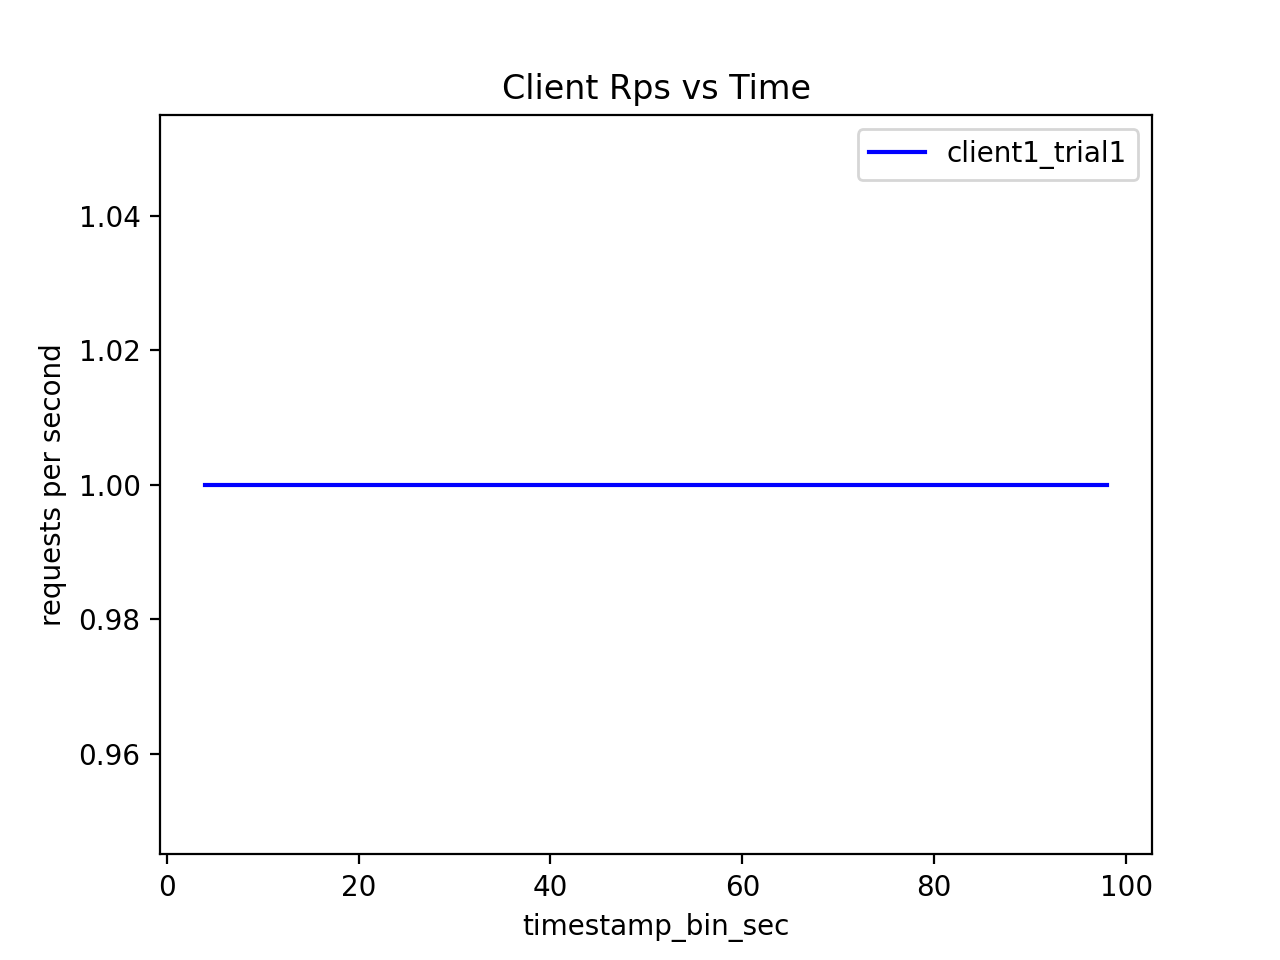

,timestamp_bin_sec,observer_id,packets_per_second
0,4.0,2,1
1,7.0,2,1
2,11.0,2,1
3,15.0,2,1
4,19.0,2,1
5,23.0,2,1
6,27.0,2,1
7,31.0,2,1
8,35.0,2,1
9,39.0,2,1


In [9]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["recv_time_sec"].min()
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "observer_id"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


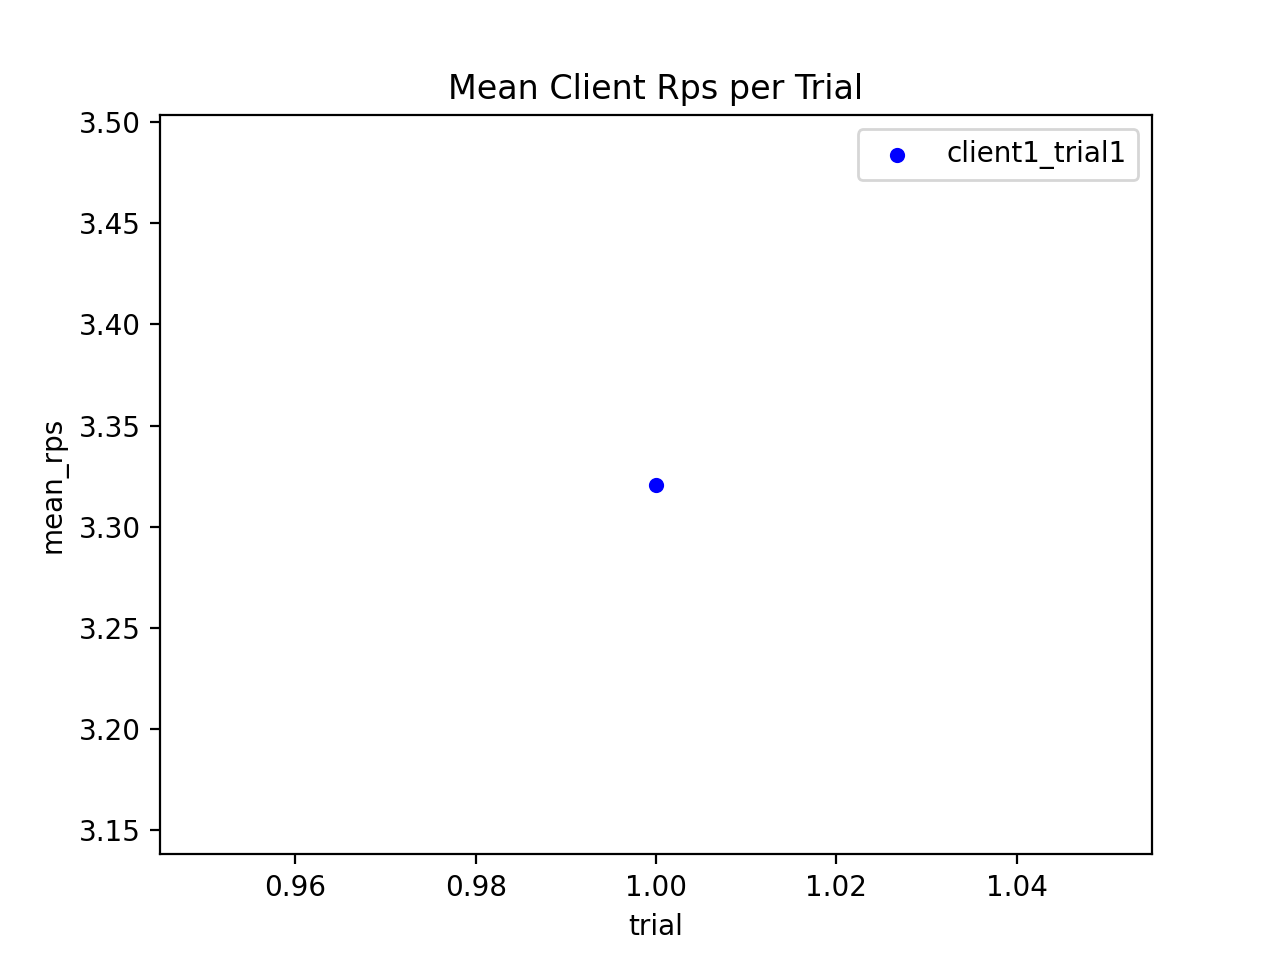

   trial  mean_rps
0      1  3.320757


,observer_id,trial,mean_rps
0,7,1,3.320757


In [20]:
gdf = rtts_df.groupby(by=["observer_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["observer_id"].unique(), start=1):
        cdf = tdf[tdf["observer_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

gdf

In [21]:
attack_dbg_sql = f"""

WITH proxy AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["proxy"]} -- proxy is observer
), proxy_from_server AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["originserver"]} AND dst_id = {node_map_node_id["proxy"]} -- server --> proxy
), proxy_from_attacker AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["receiver"]} AND dst_id = {node_map_node_id["proxy"]} -- attacker (spoofing as receiver) --> proxy
), exp_server AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["originserver"]} -- server is observer
), server_from_proxy AS (
SELECT 
	*
FROM 
	exp_server
WHERE
	src_id = {node_map_node_id["proxy"]} AND dst_id = {node_map_node_id["originserver"]} -- proxy --> server
), receiver AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["receiver"]} -- receiver is observer
), experiment_timestamps AS (
SELECT 
	MIN(x.observe_timestamp) AS min_timestamp,
	MAX(x.observe_timestamp) AS max_timestamp
FROM 
	event x 
WHERE 
	x.observer_id = {node_map_dnid["proxy"]} OR x.observer_id IN ({','.join(map(str, client_dnids))}) -- proxy or client
), main_table AS (
SELECT 
	dn.exp_id,
	e.trial,
	e.message_marker,
	
	r.coap_type,
	r.coap_code,
	r.coap_retransmitted,
	
	sfp.src_id AS sfp_src_id,
	sfp.dst_id AS sfp_dst_id,
	
	e.observe_timestamp - min_timestamp   AS a_observe_timestamp,
	pfa.observe_timestamp - min_timestamp AS pfa_observe_timestamp,
	sfp.observe_timestamp - min_timestamp AS sfp_observe_timestamp,
	pfs.observe_timestamp - min_timestamp AS pfs_observe_timestamp,
	r.observe_timestamp - min_timestamp   AS r_observe_timestamp,
	
	1e3 * (pfa.observe_timestamp - e.observe_timestamp)   AS attacker_to_proxy_ms,
	1e3 * (sfp.observe_timestamp - pfa.observe_timestamp) AS proxy_to_server_ms,
	1e3 * (pfs.observe_timestamp - sfp.observe_timestamp) AS server_to_proxy_ms,
	1e3 * (r.observe_timestamp   - pfs.observe_timestamp) AS proxy_to_receiver_ms,
	1e3 * (r.observe_timestamp   - e.observe_timestamp)   AS attacker_to_receiver_ms
FROM
	event e
	JOIN deployed_node dn             ON dn.dnid            = e.observer_id
	LEFT JOIN proxy_from_attacker pfa ON pfa.message_marker  = e.message_marker
	LEFT JOIN server_from_proxy sfp   ON sfp.message_marker = e.message_marker
	LEFT JOIN proxy_from_server pfs   ON pfs.message_marker = e.message_marker
	LEFT JOIN receiver r              ON r.message_marker   = e.message_marker
	, experiment_timestamps
WHERE 
	e.observer_id = {node_map_dnid["attacker"]} -- attacker is observer for e
), main_table_summary AS (
	SELECT
		COUNT(DISTINCT x.message_marker) AS num_unique_messages,
		COUNT(x.message_marker) AS num_messages
	FROM
		main_table x
), massaged_main_table AS (
SELECT 
	mts.*,
	mt.*
FROM
	main_table mt,
	main_table_summary mts
ORDER BY
	mt.exp_id,
	mt.trial,
	mt.message_marker
), duplicate_messages AS (
SELECT a.*
FROM massaged_main_table a
JOIN (SELECT exp_id, trial, message_marker, COUNT(*)
FROM massaged_main_table 
GROUP BY exp_id, trial, message_marker
HAVING count(*) > 1 ) b
ON a.exp_id = b.exp_id
AND a.trial = b.trial
AND a.message_marker = b.message_marker
ORDER BY a.exp_id, a.trial, a.message_marker
)

SELECT *
FROM massaged_main_table 
;
"""

adbgdf = pd.read_sql_query(attack_dbg_sql, con)
adbgdf["sent_time_ms"] = adbgdf["a_observe_timestamp"]
adbgdf.sort_values(by="sent_time_ms", inplace=True)
con.commit()

adbgdf

,num_unique_messages,num_messages,exp_id,trial,message_marker,coap_type,coap_code,coap_retransmitted,sfp_src_id,sfp_dst_id,...,pfa_observe_timestamp,sfp_observe_timestamp,pfs_observe_timestamp,r_observe_timestamp,attacker_to_proxy_ms,proxy_to_server_ms,server_to_proxy_ms,proxy_to_receiver_ms,attacker_to_receiver_ms,sent_time_ms
0,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,101,ack,content,False,4.0,1.0,...,20.902355,21.207499,21.307296,21.559460,2.018929,305.143833,99.797010,252.164125,659.123898,20.900336
1,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,101,ack,content,False,4.0,1.0,...,20.902344,21.207499,21.307296,21.559460,2.007961,305.154800,99.797010,252.164125,659.123898,20.900336
2,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,102,ack,content,False,4.0,1.0,...,20.902359,21.206754,21.306604,21.558984,2.019167,304.394960,99.849939,252.380133,658.644199,20.900340
3,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,102,ack,content,False,4.0,1.0,...,20.902361,21.206754,21.306604,21.558984,2.021074,304.393053,99.849939,252.380133,658.644199,20.900340
4,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,103,ack,content,False,4.0,1.0,...,20.902363,21.206543,21.306349,21.559226,2.020836,304.180145,99.805832,252.877235,658.884048,20.900342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039408,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,520992,ack,bad_gateway,False,NaN,NaN,...,40.754411,NaN,NaN,53.091651,2.002001,NaN,NaN,NaN,12339.241982,40.752409
1039409,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,520993,ack,bad_gateway,False,NaN,NaN,...,40.754413,NaN,NaN,53.090846,1.952887,NaN,NaN,NaN,12338.385820,40.752460
1039410,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,520993,ack,bad_gateway,False,NaN,NaN,...,40.754414,NaN,NaN,53.090846,1.953840,NaN,NaN,NaN,12338.385820,40.752460
1039411,520891,1039413,quadruple_delay_full_monitoring_5sectimeout_90...,1,520994,ack,bad_gateway,False,NaN,NaN,...,40.754646,NaN,NaN,53.091929,2.127886,NaN,NaN,NaN,12339.411020,40.752518


In [22]:
adbgdf[(adbgdf["attacker_to_receiver_ms"] > 30000) & (adbgdf["coap_code"] != "bad_gateway")]

,num_unique_messages,num_messages,exp_id,trial,message_marker,coap_type,coap_code,coap_retransmitted,sfp_src_id,sfp_dst_id,...,pfa_observe_timestamp,sfp_observe_timestamp,pfs_observe_timestamp,r_observe_timestamp,attacker_to_proxy_ms,proxy_to_server_ms,server_to_proxy_ms,proxy_to_receiver_ms,attacker_to_receiver_ms,sent_time_ms


<IPython.core.display.Javascript object>


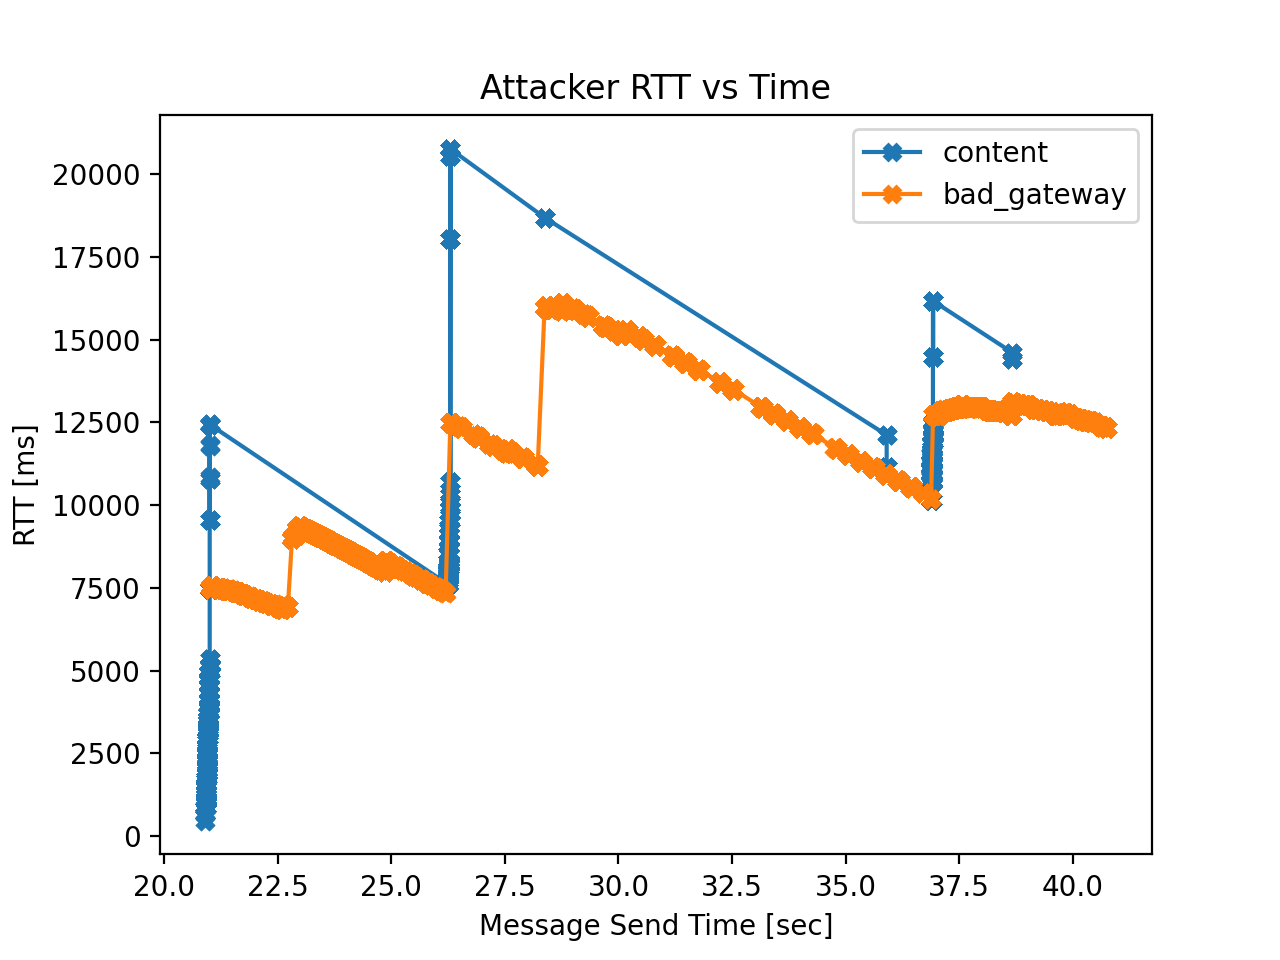

In [26]:
# Plot attacker rtt vs time

ax = None
x="sent_time_ms"
y="attacker_to_receiver_ms"
kind="line"
for coap_code in adbgdf["coap_code"].unique():
    if coap_code is None:
        continue
    _df = adbgdf[adbgdf["coap_code"] == coap_code]
    plot_args = {"kind": kind,
                 "x": x,
                 "y": y,
                 "ax": ax,
                 "marker": "X",
                 "label": coap_code}
    ax = _df.plot(**plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

<IPython.core.display.Javascript object>


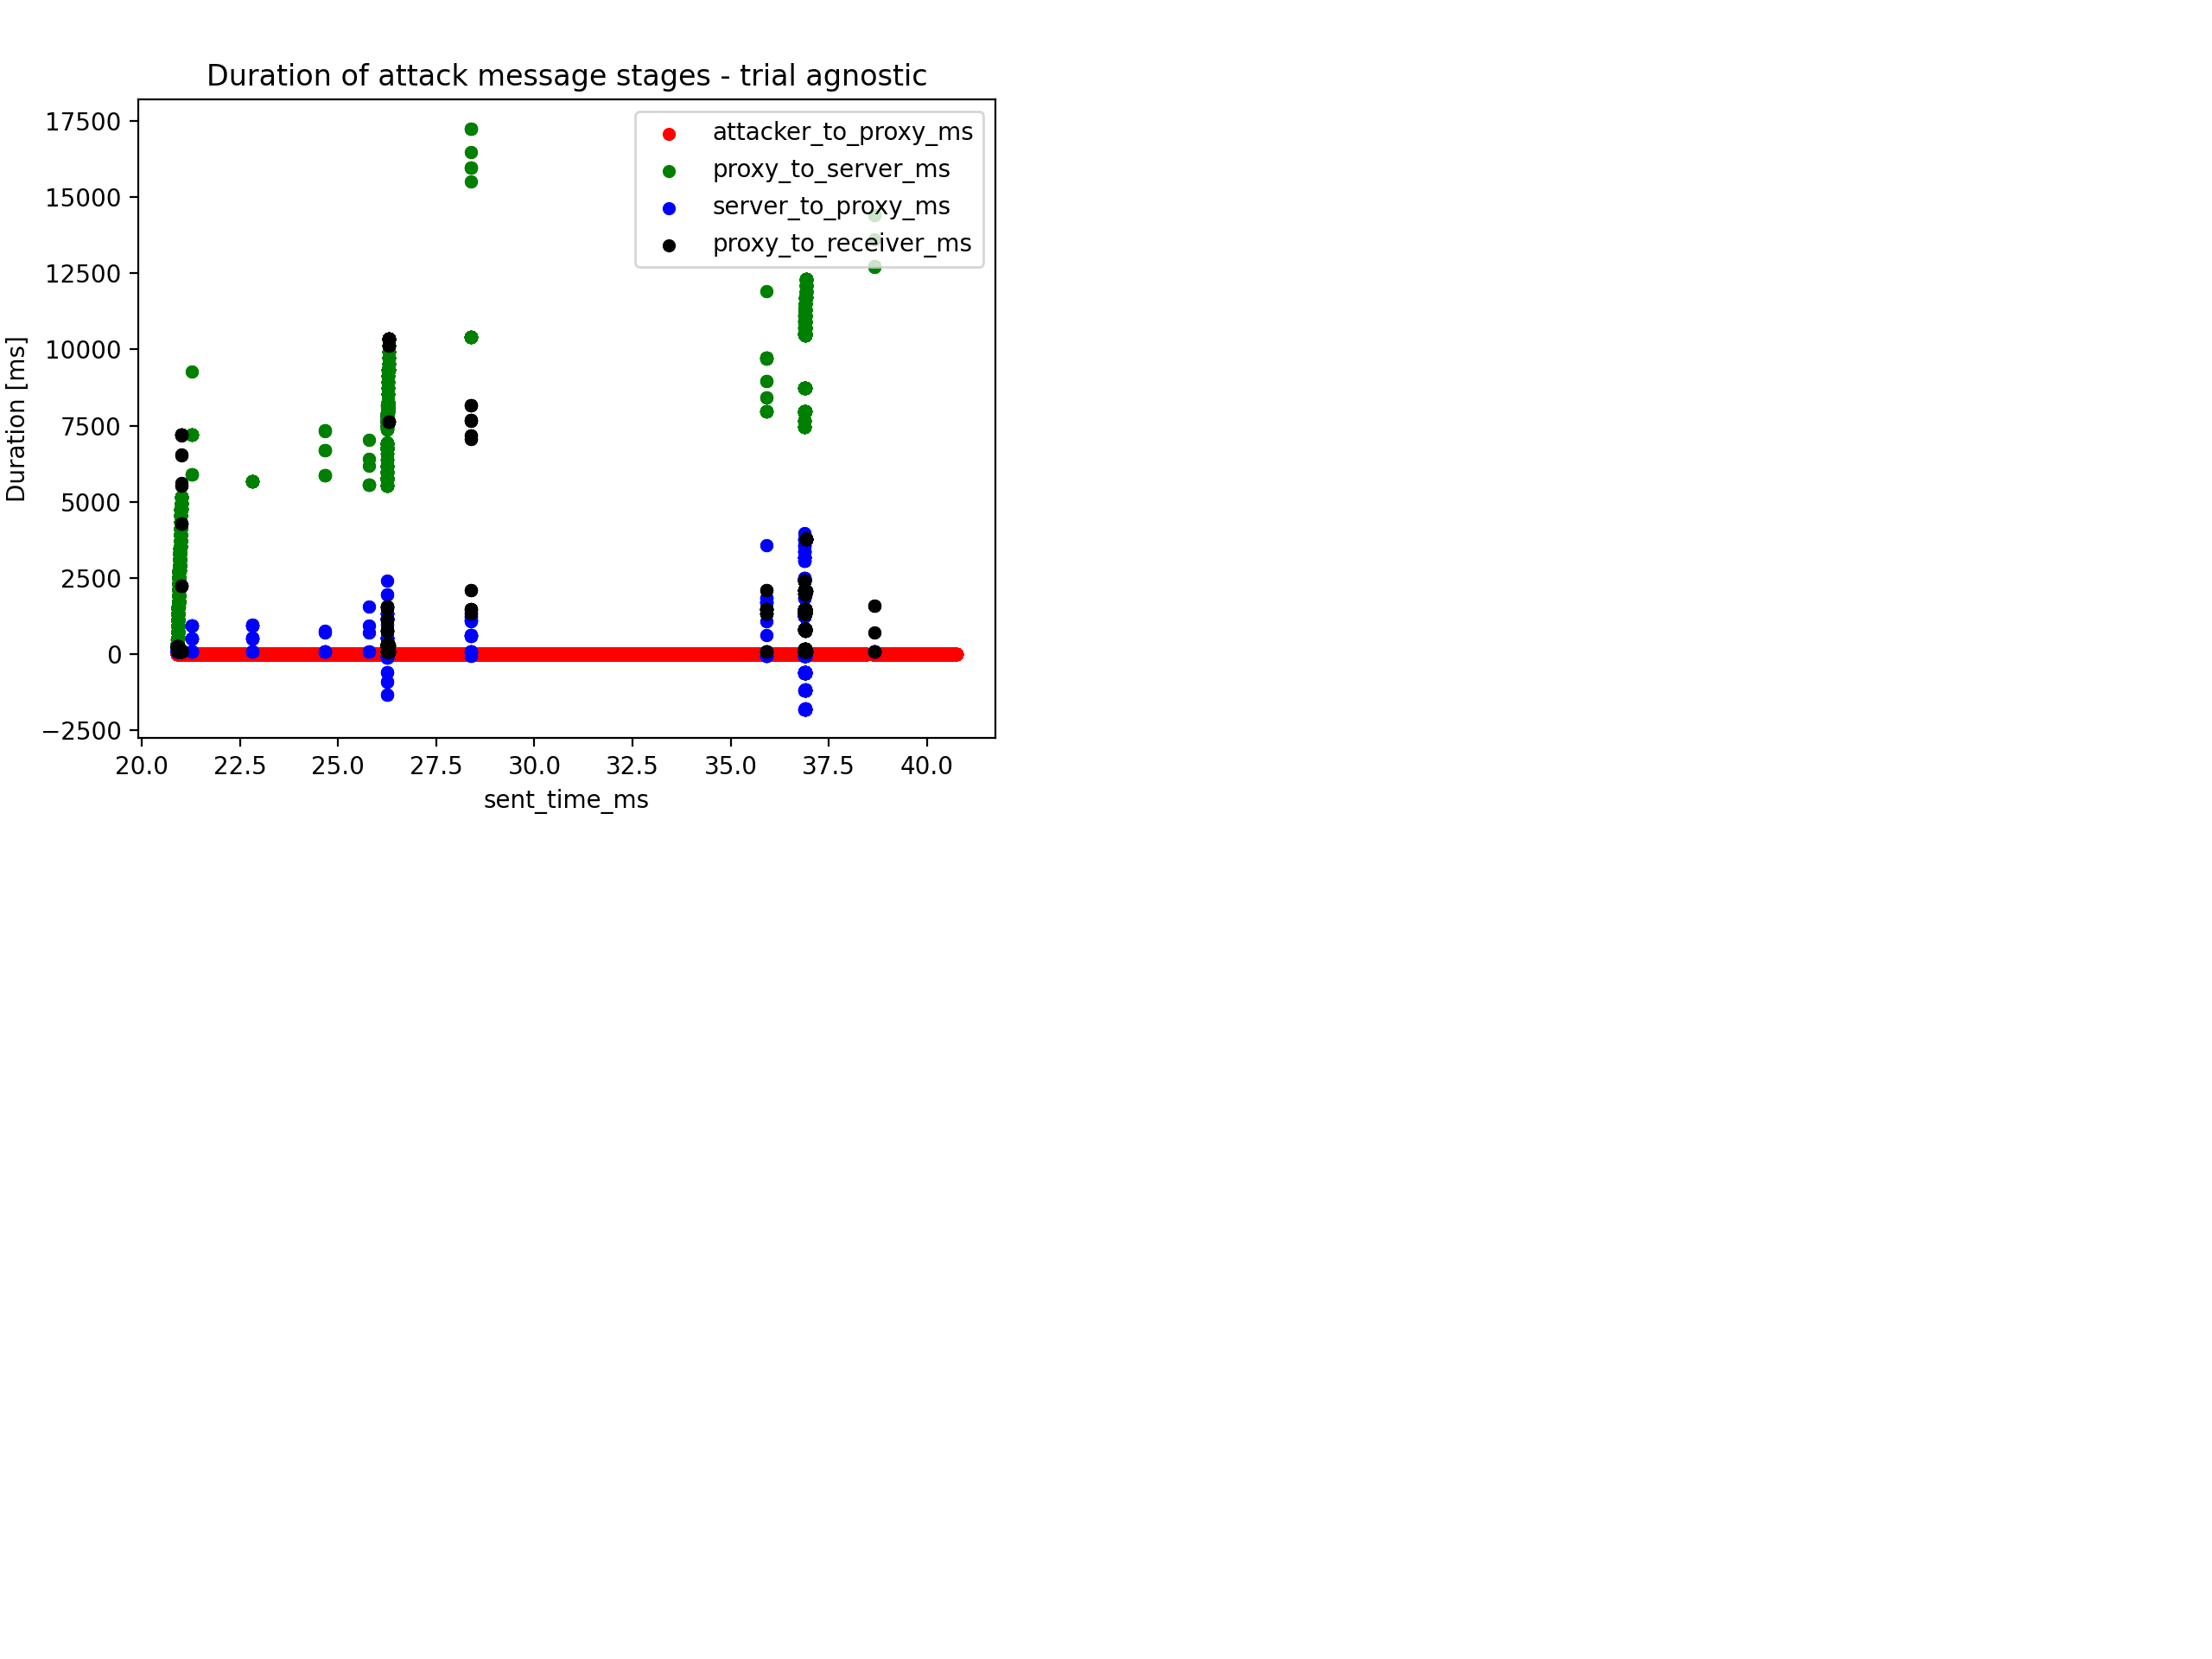

In [24]:
# Plot the duration of different stages of the attack messages

x="sent_time_ms"
kind="scatter"
ax = None
ax = adbgdf.plot(kind=kind, x=x, y="attacker_to_proxy_ms", ax=ax, label="attacker_to_proxy_ms", color='red')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_server_ms", ax=ax, label="proxy_to_server_ms", color='green')
ax = adbgdf.plot(kind=kind, x=x, y="server_to_proxy_ms", ax=ax, label="server_to_proxy_ms", color='blue')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_receiver_ms", ax=ax, label="proxy_to_receiver_ms", color='black')

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()